In [1]:
#default_exp lightning.core

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from typing import Optional, Callable, Union
import albumentations as A
import pandas as pd
import wandb

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.metrics.functional.classification import accuracy
from pytorch_lightning import _logger as log
from functools import partial

from src.core import *
from src.layers import *
from src.mixmethods import *
from src.networks import *

In [3]:
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [6]:
#export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"
    def __init__(self, df_path:str, im_dir:str, curr_fold: int,
                 train_augs: A.Compose, valid_augs: A.Compose, bs: int = 64, 
                 num_workers: int=0):
        
        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.curr_fold = curr_fold
        self.train_augs, self.valid_augs = train_augs, valid_augs
        self.bs, self.workers = bs, num_workers
    
    def prepare_data(self):
        log.info(f'Generating data for fold: {self.curr_fold}')
        self.train_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == True]
            
        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)
            
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds  = ImageClassificationFromDf(self.valid_df, self.valid_augs)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers)

In [7]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(grid);

In [21]:
#export

#TODO: add midlevel classification branch in learning.
class LightningCassava(pl.LightningModule):
    """LightningModule wrapper for `TransferLearningModel`"""
    def __init__(self, model: Union[TransferLearningModel, SnapMixTransferLearningModel], conf:dict):
        super().__init__()
        
        self.model = model
    
        # save hyper-parameters
        self.save_hyperparameters(conf)
        
        try    : mixmethod = object_from_dict(self.hparams["mixmethod"])
        except : mixmethod = None
            
        self.mix_fn = mixmethod
        self.loss_func = object_from_dict(self.hparams["loss_function"])
        
        if self.mix_fn is not None:
            log.info(f'Mixmethod : {self.mix_fn.__class__.__name__}')
        
        log.info(f'Loss Function : {self.loss_func}')
        
        self.val_labels_list = []
        self.val_preds_list  = []
        self.one_batch_of_image = None
        
        self.train_accuracy = pl.metrics.Accuracy()
        self.valid_accuracy = pl.metrics.Accuracy()
        self.test_accuracy  = pl.metrics.Accuracy()
        
    def forward(self, xb):  
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss  = self.mix_fn.loss(self.loss_func, y_hat)
        
        else:
            y_hat = self(x)
            loss  = self.loss_func(y_hat, y)
        
        self.one_batch_of_image = x
            
        train_acc = self.train_accuracy(y_hat, y)
            
        self.log('train/loss', loss, on_epoch=True)
        self.log('train/acc',  train_acc, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.loss_func(y_hat, y)
        acc   = self.valid_accuracy(y_hat, y)
        
        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()
        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)
        
        metrics = {'valid/loss': loss, 'valid/acc': acc}
        self.log_dict(metrics, prog_bar=True, logger=True,)
        return metrics
    
    def test_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.loss_func(y_hat, y)
        acc   = self.test_accuracy(y_hat, y)
        
        metrics = {'test/loss': loss, 'test/acc': acc}
        self.log_dict(metrics, on_step=False, on_epoch=True, logger=True)
        return metrics
        
    def configure_optimizers(self):
        base_lr = self.hparams["learning_rate"]
        
        param_list = [
            {'params': self.param_list[0], 'lr': base_lr/self.hparams["lr_mult"]},
            {'params': self.param_list[1], 'lr': base_lr}
        ]
        
        opt = object_from_dict(self.hparams["optimizer"], params=param_list)
        
        if self.hparams["scheduler"] is not None:
            
            if self.hparams["scheduler"]["type"] == "torch.optim.lr_scheduler.OneCycleLR":
                lr_list = [base_lr/self.hparams["lr_mult"], base_lr]
                kwargs = dict(optimizer=opt, max_lr=lr_list, steps_per_epoch=len(self.train_dataloader()))
                sch = object_from_dict(self.hparams["scheduler"], **kwargs)           
            
            else:
                sch = object_from_dict(self.hparams["scheduler"], optimizer=opt)
                
            # convert scheduler to lightning format
            sch = {'scheduler': sch, 
                   'monitor'  : self.hparams['metric_to_track'], 
                   'interval' : self.hparams['step_after'], 
                   'frequency': self.hparams['frequency']}
            
            return [opt], [sch]
        
        else: 
            return [opt]
        
    @property
    def param_list(self):
        if isinstance(self.model, SnapMixTransferLearningModel):
            param_list = [params(self.model.encoder), params(self.model.fc)+params(self.model.ls)]
        else:
            param_list = [params(self.model.encoder), params(self.model.fc)]
        return param_list
    
    def save_model_weights(self, path:str):
        state = self.model.state_dict()
        torch.save(state, path)
        log.info(f'weights saved to {path}')
        
    def load_model_weights(self, path:str):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        log.info(f'weights loaded from {path}')

In [22]:
#export
class WandbImageClassificationCallback(pl.Callback):
    """ Custom callback to add some extra functionalites to the wandb logger """
    
    def __init__(self, 
                 dm: CassavaLightningDataModule, 
                 default_config: dict = None, 
                 num_batches:int = 16):
        
        # class names for the confusion matrix
        self.class_names = list(conf_mat_idx2lbl.values())
        
        # counter to log training batch images
        self.dm = dm
        self.num_bs = num_batches
        self.curr_epoch = 0
        
        if default_config is None: default_config = []
        
        self.default_config = default_config
        
    def on_train_start(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        try:
            # log model to the wandb experiment
            wandb.watch(models=pl_module.model, criterion=pl_module.loss_func)
        except:
            log.info("Skipping wandb.watch --->")
            
        train_augs, valid_augs = self.dm.train_augs, self.dm.valid_augs
        self.default_config['train_augments'] = train_augs
        self.default_config['valid_augments'] = valid_augs
        
        try: 
            wandb.config.update(self.default_config)
            log.info("wandb config updated -->")
        except: 
            log.info("Skipping update wandb config -->")
        
    def on_train_epoch_end(self, trainer, pl_module, *args, **kwargs):
        if pl_module.one_batch_of_image is None:
            log.info(f"{self.config_defaults['mixmethod']} samples not available . Skipping --->")
            pass
        
        else:
            one_batch = pl_module.one_batch_of_image[:self.num_bs]
            train_ims = one_batch.data.to('cpu')
            trainer.logger.experiment.log({"train_batch": [wandb.Image(x) for x in train_ims]}, commit=False)
            
    def on_epoch_start(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        pl_module.val_labels_list = []
        pl_module.val_preds_list  = []
    
    def on_epoch_end(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        val_preds  = torch.tensor(pl_module.val_preds_list).data.cpu().numpy()
        val_labels = torch.tensor(pl_module.val_labels_list).data.cpu().numpy()
        
        # Log confusion matrix
        wandb.log({'conf_mat': wandb.plot.confusion_matrix(val_preds,val_labels,self.class_names)}, commit=False)

In [23]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(limit=0.1),
    A.HueSaturationValue(20, 20, 20),
    A.HorizontalFlip(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, 
                                valid_augs=valid_augs, bs=32, num_workers=0)
dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()

Generating data for fold: 0


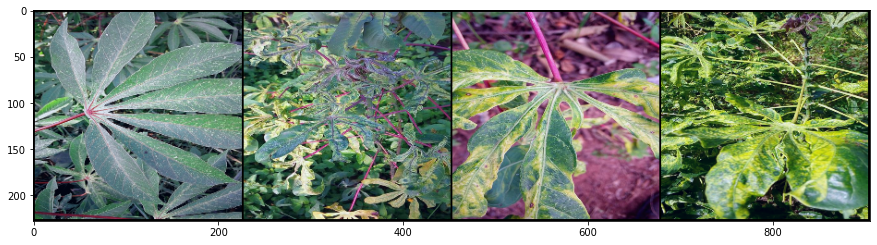

In [24]:
make_show_grid(train_dl)

In [25]:
#export
example_conf = dict(
    mixmethod = dict(type='src.mixmethods.SnapMix', alpha=5.0, conf_prob=1.0),
    loss_function = dict(type='src.core.LabelSmoothingCrossEntropy', eps=0.1),
    learning_rate = 1e-03,
    lr_mult = 100,
    optimizer = dict(type='torch.optim.Adam', betas=(0.9, 0.99), eps=1e-06, weight_decay=0),
    scheduler = dict(type='torch.optim.lr_scheduler.CosineAnnealingWarmRestarts', T_0=10, T_mult=2),
    metric_to_track = None,
    step_after = "step",
    frequency = 1,
)

In [26]:
encoder = timm.create_model('resnet18', pretrained=False)
model = SnapMixTransferLearningModel(encoder, cut=-2, c=5, act=nn.ReLU(inplace=True))
model = LightningCassava(model=model, conf=example_conf)

Mixmethod : SnapMix
Loss Function : LabelSmoothingCrossEntropy()


In [27]:
model.hparams

"frequency":       1
"learning_rate":   0.001
"loss_function":   {'type': 'src.core.LabelSmoothingCrossEntropy', 'eps': 0.1}
"lr_mult":         100
"metric_to_track": None
"mixmethod":       {'type': 'src.mixmethods.SnapMix', 'alpha': 5.0, 'conf_prob': 1.0}
"optimizer":       {'type': 'torch.optim.Adam', 'betas': (0.9, 0.99), 'eps': 1e-06, 'weight_decay': 0}
"scheduler":       {'type': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts', 'T_0': 10, 'T_mult': 2}
"step_after":      step

In [28]:
model

LightningCassava(
  (model): SnapMixTransferLearningModel(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [29]:
opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]['scheduler']
opt, lr_scheduler

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.99)
     eps: 1e-06
     initial_lr: 1e-05
     lr: 1e-05
     weight_decay: 0
 
 Parameter Group 1
     amsgrad: False
     betas: (0.9, 0.99)
     eps: 1e-06
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts at 0x7fe5fd7f9850>)

In [30]:
example_conf = dict(
    mixmethod = None,
    loss_function = dict(type='src.core.LabelSmoothingCrossEntropy', eps=0.1),
    learning_rate = 1e-03,
    lr_mult = 100,
    optimizer = dict(type='torch.optim.Adam', betas=(0.9, 0.99), eps=1e-06, weight_decay=0),
    scheduler = dict(type='torch.optim.lr_scheduler.OneCycleLR', pct_start=0.3, epochs=2, cycle_momentum=True),
    metric_to_track = None,
    step_after = "step",
    frequency = 1,
)

encoder = timm.create_model('resnet18', pretrained=False)
model = TransferLearningModel(encoder, cut=-2, c=5, act=nn.ReLU(inplace=True))
model = LightningCassava(model=model, conf=example_conf)

Loss Function : LabelSmoothingCrossEntropy()


In [31]:
model

LightningCassava(
  (model): TransferLearningModel(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 